# Load Data
Load the data from https://www.nature.com/articles/s41597-022-01156-1.pdf 

This Dataset contains Heaptpump Data and Electrical Load. We synthethesis a PV within the destrict PV.

In [1]:
# imports
import requests
import h5py
import pandas as pd
from io import BytesIO
from tqdm.notebook import tqdm
# mathplotlib
import matplotlib.pyplot as plt

In [2]:
# hdf5 1min data
hdf5_2018 = 'https://zenodo.org/records/5642902/files/2018_data_1min.zip?download=1'
hdf5_2019 = 'https://zenodo.org/records/5642902/files/2019_data_1min.zip?download=1'
hdf5_2020 = 'https://zenodo.org/records/5642902/files/2020_data_1min.zip?download=1'

# hdf5 1h data
hdf5_2018_1h = 'https://zenodo.org/records/5642902/files/2018_data_60min.hdf5?download=1'
hdf5_2019_1h = 'https://zenodo.org/records/5642902/files/2019_data_60min.hdf5?download=1'
hdf5_2020_1h = 'https://zenodo.org/records/5642902/files/2020_data_60min.hdf5?download=1'

hdf5_1h = [hdf5_2018_1h, hdf5_2019_1h, hdf5_2020_1h]

# weather data

In [3]:
def download_hdf5(url: str) -> BytesIO:
    """
    Downloads an HDF5 file from a URL and returns a BytesIO buffer.
    """
    response = requests.get(url)
    response.raise_for_status()
    return BytesIO(response.content)

In [4]:
data = []
for hdf_url in hdf5_1h:
    print(f"Downloading {hdf_url}...")
    hdf5_buffer = download_hdf5(hdf_url)
    data.append(hdf5_buffer)

# Functions

In [5]:

def concat_dataframes_unique_index(df_list):
    # Combine all indices into a single Series
    all_indices = pd.concat([df.index.to_series() for df in df_list], ignore_index=True)

    # Convert to UTC datetime
    utc_indices = pd.to_datetime(all_indices, unit='s', utc=True)

    #
    # Checking a lot of stuff about the indices
    #

    # Sanity check for UTC conversion
    assert utc_indices.notnull().all(), "Some indices could not be converted to UTC timestamps"
    assert str(utc_indices.dt.tz) == 'UTC', "Indices are not in UTC timezone."
    # Sanity check for duplicates
    assert len(utc_indices) == utc_indices.nunique(), "Duplicate index values found across dataframes."
    # Check if all indices are sorted
    assert utc_indices.is_monotonic_increasing, "Indices are not sorted in increasing order."
    # Check if they are equally spaced
    time_diffs = utc_indices.diff().dropna()
    assert time_diffs.nunique() == 1, "Indices are not equally spaced."

    #
    # Index now contains all unique UTC timestamps from all dataframes
    #

    # Concatenate dataframes
    df_full = pd.concat(df_list, axis=0, ignore_index=True)

    # Replace the index with the UTC-converted version
    df_full.index = utc_indices

    return df_full

In [6]:
def get_data_from_buffer(file_group, data_list):
    """
    Reads HDF5 data from a BytesIO buffer and appends it to a list of DataFrames.
    """
    dfs = []
    for hdf_buf in data:
        with h5py.File(hdf_buf, "r") as h5file:
            # Navigate to the table
            table = h5file[file_group]


            # Or convert to structured array or DataFrame
            df = pd.DataFrame.from_records(table[:])
            df.set_index('index', inplace=True)
            dfs.append(df)

    df_full = concat_dataframes_unique_index(dfs)
    return df_full

In [7]:

def category_data(categorys, data, is_pv = False):

    categorys_data = {}

    for category in categorys:
        print(f"Loading {category}...")
        # extract building name
        if is_pv:
            name = category.split('/')[4]
        else:
            name = category.split('/')[1]

        try:
            df = get_data_from_buffer(category, data)
            categorys_data[name] = df
        except Exception as e:
            print(f"Error loading {category}: {e}")

    return categorys_data

# get all Buildings

In [8]:
hdf5_buffer = data[0]  # Use the first buffer for interfering building list

list_of_items = []
with h5py.File(hdf5_buffer, "r") as hdf:
    def print_structure(name, obj):
        # print(name, dict(obj.attrs))
        list_of_items.append(name)
    hdf.visititems(print_structure)


In [9]:
# filter the list of items for everthing contain table
table_items = [item for item in list_of_items if 'table' in item]
# Categorize the items based on their type
heatpumps = [item for item in table_items if 'HEATPUMP' in item]
buildings = [item for item in table_items if 'HOUSEHOLD' in item]
misc = [item for item in table_items if 'PV1' in item]

In [10]:
buidding_data = category_data(buildings, data)
heatpump_data = category_data(heatpumps, data)
misc_data = category_data(misc, data, is_pv=True)

Loading NO_PV/SFH10/HOUSEHOLD/table...
Loading NO_PV/SFH11/HOUSEHOLD/table...
Loading NO_PV/SFH12/HOUSEHOLD/table...
Loading NO_PV/SFH14/HOUSEHOLD/table...
Loading NO_PV/SFH16/HOUSEHOLD/table...
Loading NO_PV/SFH17/HOUSEHOLD/table...
Loading NO_PV/SFH18/HOUSEHOLD/table...
Loading NO_PV/SFH19/HOUSEHOLD/table...
Loading NO_PV/SFH20/HOUSEHOLD/table...
Loading NO_PV/SFH21/HOUSEHOLD/table...
Loading NO_PV/SFH22/HOUSEHOLD/table...
Loading NO_PV/SFH23/HOUSEHOLD/table...
Loading NO_PV/SFH24/HOUSEHOLD/table...
Error loading NO_PV/SFH24/HOUSEHOLD/table: 'Unable to synchronously open object (component not found)'
Loading NO_PV/SFH25/HOUSEHOLD/table...
Error loading NO_PV/SFH25/HOUSEHOLD/table: 'Unable to synchronously open object (component not found)'
Loading NO_PV/SFH27/HOUSEHOLD/table...
Loading NO_PV/SFH28/HOUSEHOLD/table...
Loading NO_PV/SFH29/HOUSEHOLD/table...
Loading NO_PV/SFH3/HOUSEHOLD/table...
Loading NO_PV/SFH30/HOUSEHOLD/table...
Loading NO_PV/SFH31/HOUSEHOLD/table...
Loading NO_PV/S

In [11]:
display(buidding_data.keys())
display(heatpump_data.keys())
display(misc_data.keys())

dict_keys(['SFH10', 'SFH11', 'SFH12', 'SFH14', 'SFH16', 'SFH17', 'SFH18', 'SFH19', 'SFH20', 'SFH21', 'SFH22', 'SFH23', 'SFH27', 'SFH28', 'SFH29', 'SFH3', 'SFH30', 'SFH31', 'SFH32', 'SFH34', 'SFH35', 'SFH36', 'SFH37', 'SFH38', 'SFH39', 'SFH4', 'SFH40', 'SFH5', 'SFH6', 'SFH7', 'SFH8', 'SFH9', 'SFH13', 'SFH15', 'SFH26', 'SFH33'])

dict_keys(['SFH10', 'SFH11', 'SFH12', 'SFH14', 'SFH16', 'SFH17', 'SFH18', 'SFH19', 'SFH20', 'SFH21', 'SFH22', 'SFH23', 'SFH27', 'SFH28', 'SFH29', 'SFH3', 'SFH30', 'SFH31', 'SFH32', 'SFH34', 'SFH35', 'SFH36', 'SFH37', 'SFH38', 'SFH39', 'SFH4', 'SFH40', 'SFH5', 'SFH6', 'SFH7', 'SFH8', 'SFH9', 'SFH13', 'SFH15', 'SFH26', 'SFH33'])

dict_keys(['EAST', 'SOUTH', 'WEST'])

In [12]:
def generate_prosumption_df(buidding_data, heatpump_data, misc_data, building_name, misc_key='EAST', pv_factor=0.5, heatpump_factor=1.0):
    """
    Generates a DataFrame with the prosumption data for a given building.
    """
    prosumption = buidding_data[building_name]['P_TOT'] + heatpump_factor * heatpump_data[building_name]['P_TOT'] - pv_factor * misc_data[misc_key]['P_TOT']
    prosumption.dropna(inplace=True)
    prosumption_df = pd.DataFrame(prosumption)

    prosumption_df["Building P_TOT"] = buidding_data[building_name]['P_TOT']
    prosumption_df["Heatpump P_TOT"] = heatpump_factor * heatpump_data[building_name]['P_TOT']
    prosumption_df["Misc P_TOT"] = pv_factor * misc_data[misc_key]['P_TOT']


    return prosumption_df

In [13]:
def vizualize_prosumption(prosumption_df, title='Prosumption Data', figsize=(10, 5)):
    """
    Visualizes the prosumption data.
    """
    prosumption_df["P_TOT"].plot(title='Prosumption SFH3', figsize=(10, 5))
    plt.xlabel('Time')
    plt.ylabel('Power (W)')
    plt.title(title)
    plt.grid()
    plt.show()


    #
    # May 2019 visualization as static example
    #

    prosumption_df.loc['2019-05-01':'2019-06-01'].plot(title='Prosumption SFH3 in May 2019', figsize=(10, 5))
    plt.xlabel('Time')
    plt.ylabel('Power (W)')
    plt.title(title + ' in May 2019')
    plt.grid()
    plt.show()

    #
    # Train Val Test split visualization as static Example
    #

    # Splits the prosumption data
    # first year train, second year validation, third year test

    start = prosumption_df.index[0]
    train_end = start + pd.DateOffset(years=1)
    val_end = train_end + pd.DateOffset(years=1)
    end = prosumption_df.index[-1]

    display(f"Train period: {start} to {train_end}  contains {val_end - start}")
    display(f"Validation period: {train_end} to {val_end}  contains {val_end - train_end}") 

    display(f"Test period: {val_end} to {end} contains {prosumption_df.index[-1] - val_end}")


    # vizualize the splits as marked zones in the plot
    prosumption_df["P_TOT"].plot(title='Prosumption SFH3 with splits', figsize=(10, 5))
    plt.axvspan(start, train_end, color='green', alpha=0.3, label='Train')
    plt.axvspan(train_end, val_end, color='orange', alpha=0.3, label='Validation')
    plt.axvspan(val_end, prosumption_df.index[-1], color='red', alpha=0.3, label='Test')
    plt.legend() 
        


### General canidates with respect to the paper are 3,4,9,18,19,26,27,28,29,39,32,33

# Generate one exemplary version of Prosumption


# SFH3

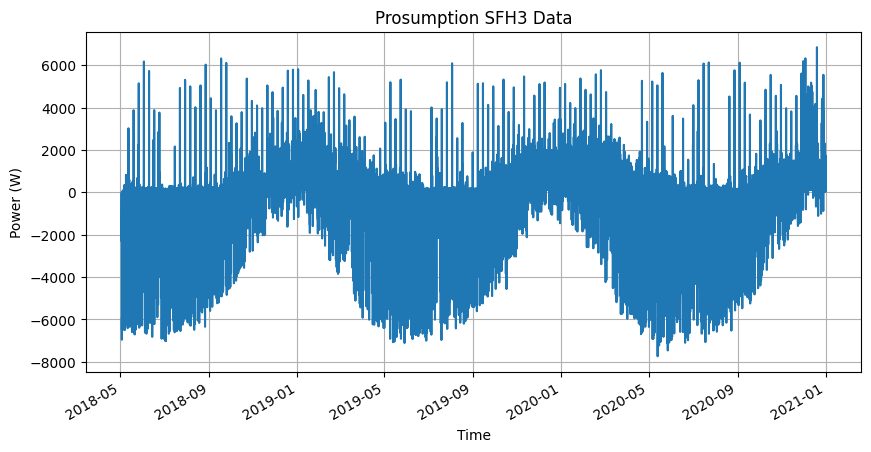

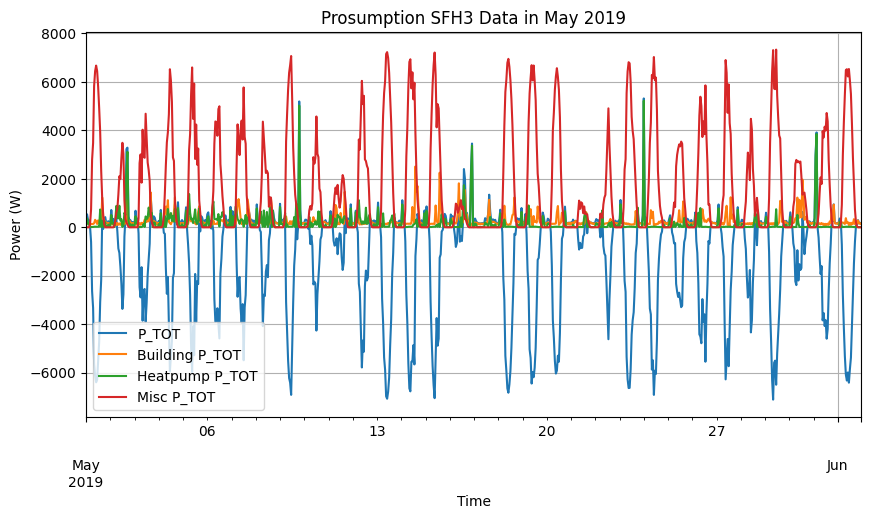

'Train period: 2018-05-02 14:00:00+00:00 to 2019-05-02 14:00:00+00:00  contains 731 days 00:00:00'

'Validation period: 2019-05-02 14:00:00+00:00 to 2020-05-02 14:00:00+00:00  contains 366 days 00:00:00'

'Test period: 2020-05-02 14:00:00+00:00 to 2020-12-31 23:00:00+00:00 contains 243 days 09:00:00'

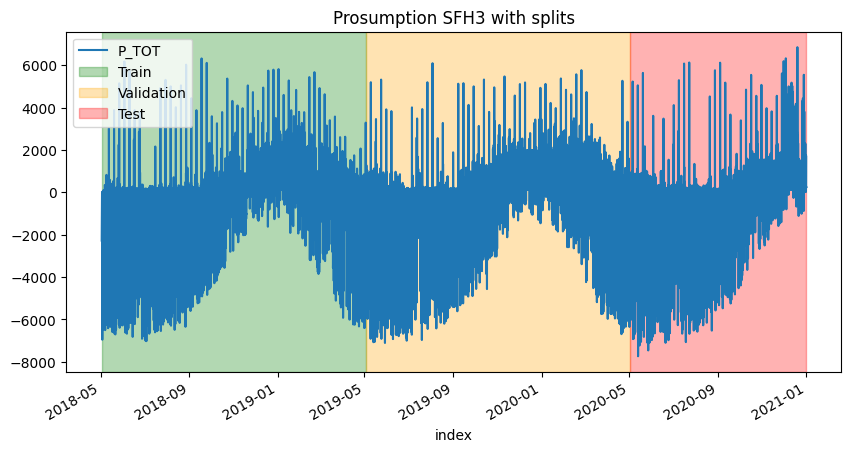

In [14]:
prosumption_sfh3_df = generate_prosumption_df(buidding_data, heatpump_data, misc_data, 'SFH3', misc_key='EAST', pv_factor=0.5, heatpump_factor=1.0)
vizualize_prosumption(prosumption_sfh3_df, title='Prosumption SFH3 Data')


# SFH 9

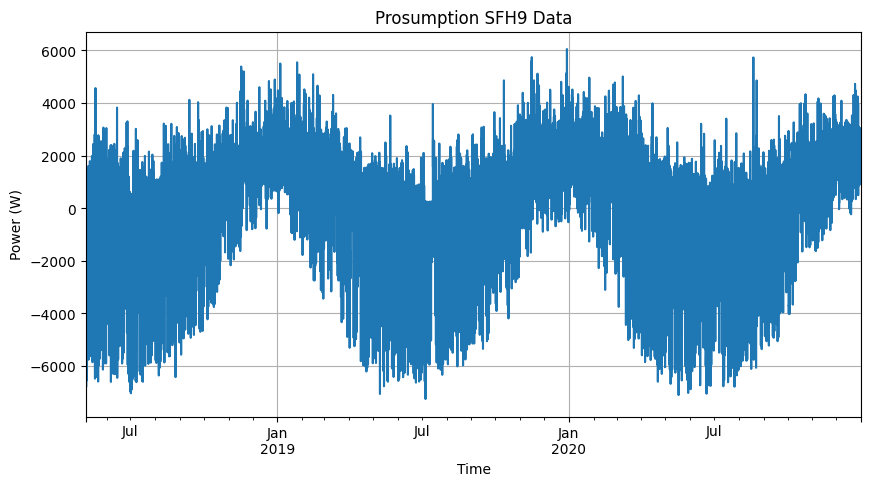

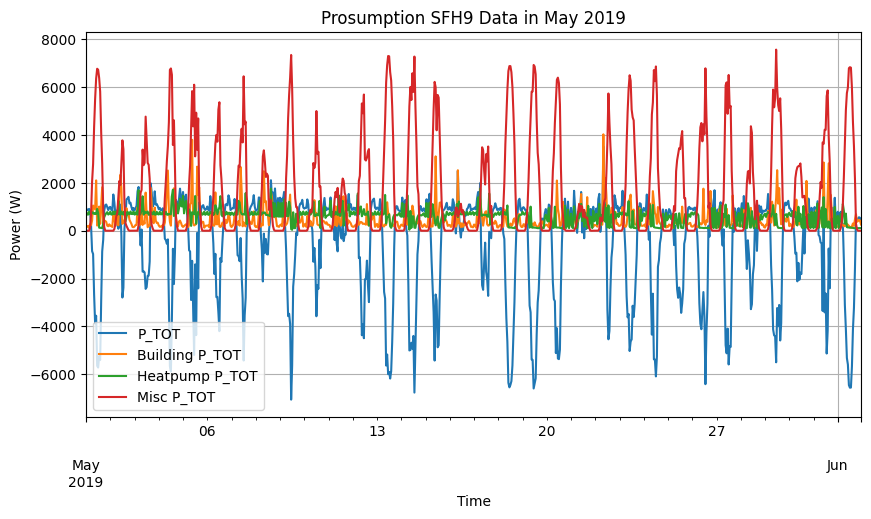

'Train period: 2018-05-06 08:00:00+00:00 to 2019-05-06 08:00:00+00:00  contains 731 days 00:00:00'

'Validation period: 2019-05-06 08:00:00+00:00 to 2020-05-06 08:00:00+00:00  contains 366 days 00:00:00'

'Test period: 2020-05-06 08:00:00+00:00 to 2020-12-31 23:00:00+00:00 contains 239 days 15:00:00'

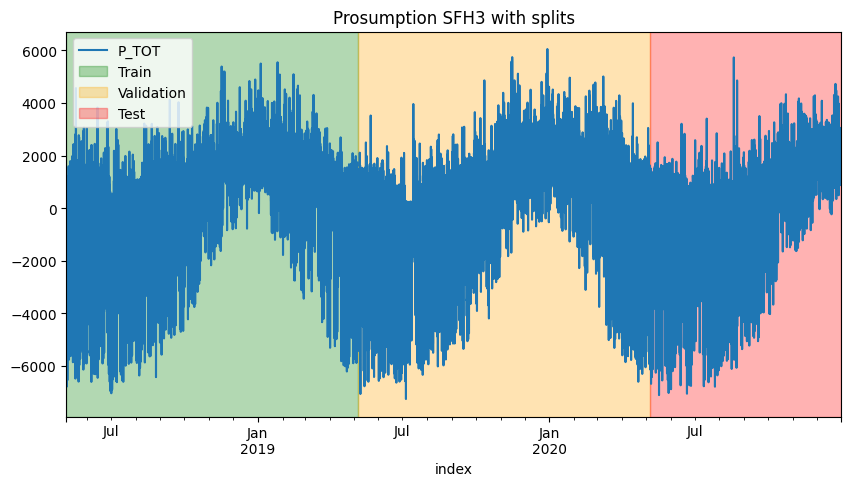

In [15]:
prosumption_sfh9_df = generate_prosumption_df(buidding_data, heatpump_data, misc_data, 'SFH9', misc_key='WEST', pv_factor=0.5, heatpump_factor=1.0)
vizualize_prosumption(prosumption_sfh9_df, title='Prosumption SFH9 Data')

# SFH 4

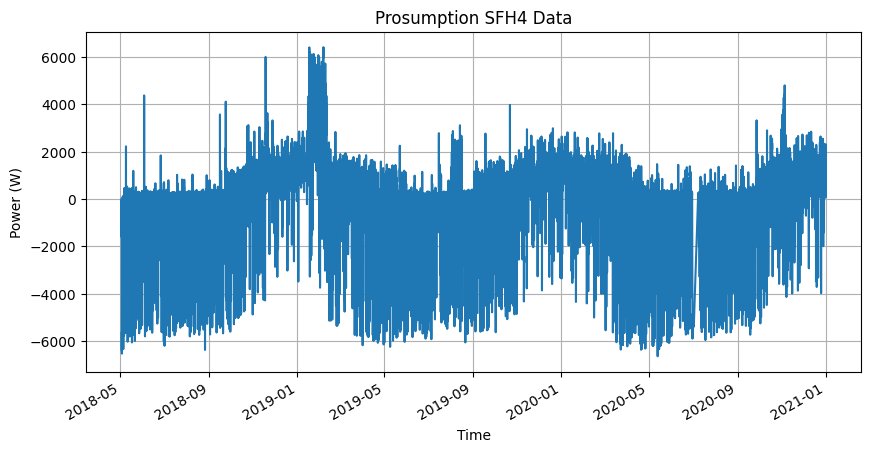

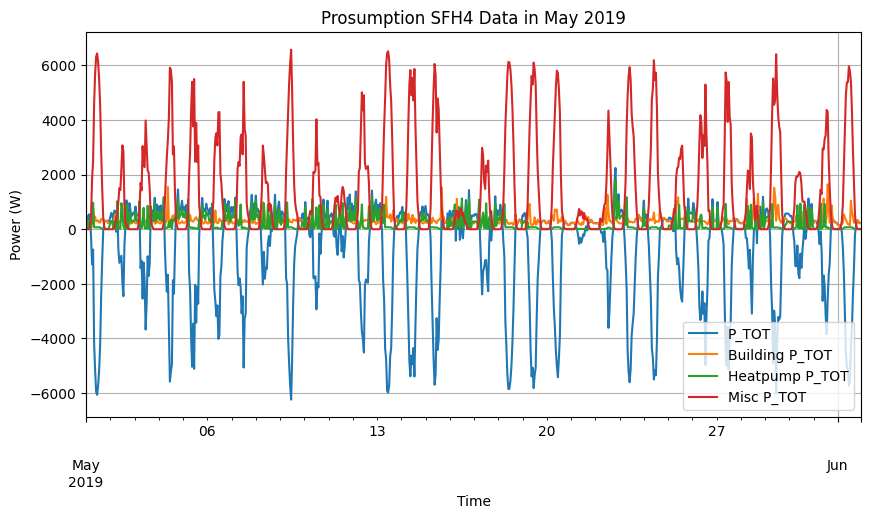

'Train period: 2018-05-02 15:00:00+00:00 to 2019-05-02 15:00:00+00:00  contains 731 days 00:00:00'

'Validation period: 2019-05-02 15:00:00+00:00 to 2020-05-02 15:00:00+00:00  contains 366 days 00:00:00'

'Test period: 2020-05-02 15:00:00+00:00 to 2020-12-31 23:00:00+00:00 contains 243 days 08:00:00'

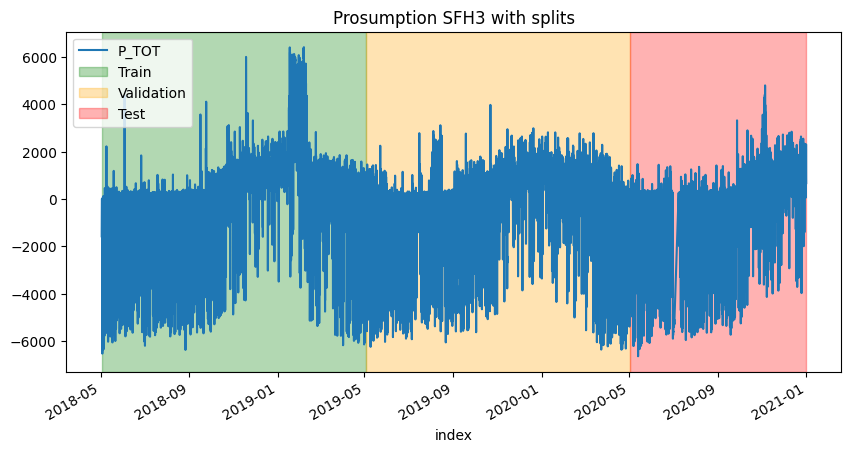

In [16]:
prosumption_sfh4_df = generate_prosumption_df(buidding_data, heatpump_data, misc_data, 'SFH4', misc_key='SOUTH', pv_factor=0.5, heatpump_factor=1.0)
vizualize_prosumption(prosumption_sfh4_df, title='Prosumption SFH4 Data')